
### Group Project Descriptive & Predictive Analytics
### DSC Re-Activation Campaign

#### 1. Importing Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing     import StandardScaler
from pandas                    import DataFrame
from pandas                    import read_csv
from numpy                     import array
from numpy                     import random
from sklearn.linear_model      import LogisticRegression 
from sklearn.metrics           import auc
from sklearn.metrics           import roc_auc_score
from matplotlib                import pyplot
from datetime                  import datetime
from scipy.stats               import pearsonr
from sklearn.model_selection   import train_test_split
from sklearn.tree              import DecisionTreeRegressor  
from sklearn.metrics           import r2_score
from sklearn.metrics           import roc_curve
from sklearn.metrics           import confusion_matrix
from sklearn.ensemble          import BaggingClassifier
from sklearn.ensemble          import GradientBoostingClassifier
from sklearn.decomposition     import PCA

In [2]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
import scikitplot as skplt

#### 2. Importing the databases: 

In [5]:
# Defining paths

directory = "C:/Users/azambranollano/Documents/Alejandra/Descriptive & Predictive Analytics/Project"
campaign13 = directory + "/campaign20130411.csv"
campaign14 = directory + "/campaign20140115.csv"
donors = directory + "/donors.csv"
gifts = directory + "/gifts.csv"

In [6]:
# Importing databases

campaign13_data = read_csv(campaign13 , sep = ";")
campaign14_data = read_csv(campaign14 , sep = ";")
donors_data = read_csv(donors , sep = ";", decimal = ".")
gifts_data = read_csv(gifts , sep = ";", decimal = ".")

In [7]:
#Importing local libraries

from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

#### 3. Cleaning the databases: 

In [8]:
# Cleaning campaign13_data

campaign13_data["donorID"] = campaign13_data["donorID"].astype(str)
campaign13_data["amount"] = campaign13_data["amount"].astype(float)

In [9]:
# Cleaning campaign14_data

campaign14_data["donorID"] = campaign14_data["donorID"].astype(str)
campaign14_data["amount"] = campaign14_data["amount"].astype(float)

In [10]:
# Cleaning donors_data

donors_data["donorID"] = donors_data["donorID"].astype(str)

donors_data.gender[donors_data.gender == 'M'] = 'Male'
donors_data.gender[donors_data.gender == 'F'] = 'Female'
donors_data.gender[donors_data.gender == 'C'] = 'Couple'
donors_data.gender[donors_data.gender == 'S'] = 'Solo'
donors_data.gender[donors_data.gender == 'U'] = 'Unknown'

donors_data.language[donors_data.language == 'N'] = 0
donors_data.language[donors_data.language == 'F'] = 1

donors_data['zipcode']=donors_data['zipcode'].str.replace('[^0-9]','0')
donors_data.zipcode[donors_data.zipcode == 0] = '0'
donors_data.zipcode[donors_data.zipcode.isna()]='0'
donors_data["zipcode"] = donors_data["zipcode"].astype(int)

donors_data["region"] = donors_data["region"].astype(str)

In [11]:
# Creating dummies variable in varible gender

gender_ohe = pd.get_dummies(donors_data['gender'])
donors_data = donors_data.drop("gender", axis = 1)

In [12]:
# We will use zipcodes in order to identify the regions

donors_data = donors_data.drop("region", axis = 1)

In [13]:
# Provinces by zipcodes

Provinces=[]

for i in donors_data.zipcode:
    
    if((i >= 1000) & (i < 1300)):
        Provinces.append("Brussels")
    
    elif(i < 1500):
        Provinces.append("Walloon Brabant")
    
    elif(i < 2000):
        Provinces.append("Flemish Brabant")

    elif(i < 3000):
        Provinces.append("Antwerp")
    
    elif(i < 3500):
        Provinces.append("Flemish Brabant")
    
    elif(i < 4000):
        Provinces.append("Limburg")
    
    elif(i < 5000):
        Provinces.append("Liege")
    
    elif(i < 6000):
        Provinces.append("Namur")
    
    elif(i < 6600):
        Provinces.append("Hainaut")
    
    else:
        Provinces.append("Missing")


In [14]:
# States by zipcodes

States=[]

for i in donors_data.zipcode:
       
    if((i >= 1000) & (i < 1300)):
        States.append("S_Brussels")
    
    elif(i < 1500):
        States.append("S_Wallonia")
    
    elif(i < 4000):
        States.append("S_Flanders")

    elif(i < 8000):
        States.append("S_Wallonia")
    
    elif(i < 10000):
        States.append("S_Flanders")
    
    else:
        States.append("S_Missing")

    

In [15]:
# Adding columns state and province in donnors table

States=pd.DataFrame(States)
Provinces=pd.DataFrame(Provinces)
donors_data["states"]=States
donors_data["province"]=Provinces

In [16]:
# Format date in gifts data and divifing date beetwen after and before 20130410 

gifts_data['date']=pd.to_datetime(gifts_data['date'], format='%d/%m/%Y')
gifts2013=(gifts_data[gifts_data.date<=pd.to_datetime('2013-03-27')])
gifts2014=(gifts_data[gifts_data.date<=pd.to_datetime('2014-01-01')])

In [17]:
# Joining and creating dummies variables states and province

donors_data = pd.concat([donors_data,gender_ohe], axis = 1, sort = False)
states_ohe = pd.get_dummies(donors_data['states'])
provinces_ohe = pd.get_dummies(donors_data['province'])
donors_data = pd.concat([donors_data,states_ohe,provinces_ohe], axis = 1, sort = False)
donors_data = donors_data.drop(['states','province','zipcode'], axis=1)

In [18]:
# Dummies previous 2013
gifts2013["gifts last year"] = gifts2013.date.apply( lambda x:1 if x> datetime(2012, 1, 1) else 0)
gifts2013["gifts last 2year"] = gifts2013.date.apply( lambda x:1 if datetime(2012,1,1)>x> datetime(2011, 1, 1) else 0)
gifts2013["gifts last 5year"] = gifts2013.date.apply( lambda x:1 if datetime(2011,1,1)>x> datetime(2008, 1, 1) else 0)
gifts2013["gifts last 10year"] = gifts2013.date.apply( lambda x:1 if datetime(2008,1,1)>x> datetime(2003, 1, 1) else 0)
gifts2013["gifts last 23year"] = gifts2013.date.apply( lambda x:1 if datetime(2003,1,1)>x> datetime(1995, 1, 1) else 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [19]:
gifts2013["gifts last year"][gifts2013["gifts last year"]==1]=gifts2013["amount"]
gifts2013["gifts last 2year"][gifts2013["gifts last 2year"]==1]=gifts2013["amount"]
gifts2013["gifts last 5year"][gifts2013["gifts last 5year"]==1]=gifts2013["amount"]
gifts2013["gifts last 10year"][gifts2013["gifts last 10year"]==1]=gifts2013["amount"]
gifts2013["gifts last 23year"][gifts2013["gifts last 23year"]==1]=gifts2013["amount"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C

In [20]:
# Dummies previous 2014

gifts2014["gifts last year"] = gifts2014.date.apply( lambda x:1 if x> datetime(2013, 1, 1) else 0)
gifts2014["gifts last 2year"] = gifts2014.date.apply( lambda x:1 if datetime(2013, 1, 1)>x> datetime(2012, 1, 1) else 0)
gifts2014["gifts last 5year"] = gifts2014.date.apply( lambda x:1 if datetime(2012, 1, 1)>x> datetime(2009, 1, 1) else 0)
gifts2014["gifts last 10year"] = gifts2014.date.apply( lambda x:1 if datetime(2009, 1, 1)>x> datetime(2004, 1, 1) else 0)
gifts2014["gifts last 23year"] = gifts2014.date.apply( lambda x:1 if datetime(2004, 1, 1)>x> datetime(1996, 1, 1) else 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [21]:
gifts2014["gifts last year"][gifts2014["gifts last year"]==1]=gifts2014["amount"]
gifts2014["gifts last 2year"][gifts2014["gifts last 2year"]==1]=gifts2014["amount"]
gifts2014["gifts last 5year"][gifts2014["gifts last 5year"]==1]=gifts2014["amount"]
gifts2014["gifts last 10year"][gifts2014["gifts last 10year"]==1]=gifts2014["amount"]
gifts2014["gifts last 23year"][gifts2014["gifts last 23year"]==1]=gifts2014["amount"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C

#### 4. Merging the databases: 

In [22]:
# Summarizing gift_data2013

gifts_2013 = pysqldf("""

SELECT donorID, SUM(amount) AS total_amount, COUNT(date) AS nbr_donations, AVG("gifts last year") AS "avg_amount year one",sum("gifts last year">0) as "Sum gifts last year",AVG("gifts last 2year") AS "avg_amount last 2year",
SUM("gifts last 2year">0) AS "sum gifts last 2year", AVG("gifts last 5year") AS "avg_amount last 5year" ,SUM("gifts last 5year">0) AS "sum gifts last 5year",("gifts last 10year") AS "avg_amount last 10year", SUM("gifts last 10year">0) AS "sum gifts last 10year",
AVG("gifts last 23year") AS "avg_amount last 23year",SUM("gifts last 23year">0) AS "sum gifts last 23year",MAX(date) AS last_donation, MIN(date) AS first_donation,MAX(amount) AS max_gift,MIN(amount) AS min_gift
FROM gifts2013
GROUP BY donorID

""")

gifts_2013.head()

,donorID,total_amount,nbr_donations,avg_amount year one,Sum gifts last year,avg_amount last 2year,sum gifts last 2year,avg_amount last 5year,sum gifts last 5year,avg_amount last 10year,sum gifts last 10year,avg_amount last 23year,sum gifts last 23year,last_donation,first_donation,max_gift,min_gift
0,100001,178.49,12,0.00,0,0.00,0,0.0,0,0.0,5,9.874167,7,2006-12-18 00:00:00.000000,1998-10-23 00:00:00.000000,30.00,6.69
1,100002,20.00,1,0.00,0,0.00,0,20.0,1,0.0,0,0.000000,0,2010-04-09 00:00:00.000000,2010-04-09 00:00:00.000000,20.00,20.00
2,100003,18.00,5,2.00,3,1.60,2,0.0,0,0.0,0,0.000000,0,2013-01-18 00:00:00.000000,2011-08-02 00:00:00.000000,5.00,3.00
3,100004,716.22,26,0.00,0,0.00,0,0.0,0,0.0,6,20.623846,20,2005-12-19 00:00:00.000000,1995-05-18 00:00:00.000000,49.58,24.79
4,100005,14.96,4,1.25,1,1.25,1,0.0,0,0.0,0,1.240000,2,2012-12-19 00:00:00.000000,1997-11-14 00:00:00.000000,5.00,2.48


In [23]:
# Summarizing gift_data2014

gifts_2014 = pysqldf("""

SELECT donorID, SUM(amount) AS total_amount, COUNT(date) AS nbr_donations, AVG("gifts last year") AS "avg_amount year one",sum("gifts last year">0) as "Sum gifts last year",AVG("gifts last 2year") AS "avg_amount last 2year",
SUM("gifts last 2year">0) AS "sum gifts last 2year", AVG("gifts last 5year") AS "avg_amount last 5year" ,SUM("gifts last 5year">0) AS "sum gifts last 5year",("gifts last 10year") AS "avg_amount last 10year", SUM("gifts last 10year">0) AS "sum gifts last 10year",
AVG("gifts last 23year") AS "avg_amount last 23year",SUM("gifts last 23year">0) AS "sum gifts last 23year",
MAX(date) AS last_donation, MIN(date) AS first_donation,MAX(amount) AS max_gift,MIN(amount) AS min_gift
FROM gifts2014
GROUP BY donorID

""")

gifts_2014.head()

,donorID,total_amount,nbr_donations,avg_amount year one,Sum gifts last year,avg_amount last 2year,sum gifts last 2year,avg_amount last 5year,sum gifts last 5year,avg_amount last 10year,sum gifts last 10year,avg_amount last 23year,sum gifts last 23year,last_donation,first_donation,max_gift,min_gift
0,100001,178.49,12,0.000000,0,0.000000,0,0.000000,0,0.0,4,11.540833,8,2006-12-18 00:00:00.000000,1998-10-23 00:00:00.000000,30.00,6.69
1,100002,20.00,1,0.000000,0,0.000000,0,20.000000,1,0.0,0,0.000000,0,2010-04-09 00:00:00.000000,2010-04-09 00:00:00.000000,20.00,20.00
2,100003,42.00,11,2.454545,7,0.636364,2,0.727273,2,0.0,0,0.000000,0,2013-12-19 00:00:00.000000,2011-08-02 00:00:00.000000,5.00,3.00
3,100004,716.22,26,0.000000,0,0.000000,0,0.000000,0,0.0,4,21.024615,20,2005-12-19 00:00:00.000000,1995-05-18 00:00:00.000000,49.58,24.79
4,100005,24.96,5,2.000000,1,1.000000,1,1.000000,1,0.0,0,0.992000,2,2013-10-24 00:00:00.000000,1997-11-14 00:00:00.000000,10.00,2.48


In [24]:
# Cleaning data 2013

gifts_2013["avg_amount last 10year"]=gifts_2013["avg_amount last 10year"].astype(float)
gifts_2013["avg_amount year one"]=round(gifts_2013["avg_amount year one"],2)
gifts_2013["avg_amount last 2year"]=round(gifts_2013["avg_amount last 2year"],2)
gifts_2013["avg_amount last 5year"]=round(gifts_2013["avg_amount last 5year"],2)
gifts_2013["avg_amount last 10year"]=round(gifts_2013["avg_amount last 10year"],2)
gifts_2013["avg_amount last 23year"]=round(gifts_2013["avg_amount last 23year"],2)
gifts_2013['last_donation']=pd.to_datetime(gifts_2013['last_donation'], format='%Y/%m/%d')
gifts_2013['first_donation']=pd.to_datetime(gifts_2013['first_donation'], format='%Y/%m/%d')

In [25]:
# Cleaning data 2014

gifts_2014["avg_amount last 10year"]=gifts_2014["avg_amount last 10year"].astype(float)
gifts_2014["avg_amount year one"]=round(gifts_2014["avg_amount year one"],2)
gifts_2014["avg_amount last 2year"]=round(gifts_2014["avg_amount last 2year"],2)
gifts_2014["avg_amount last 5year"]=round(gifts_2014["avg_amount last 5year"],2)
gifts_2014["avg_amount last 10year"]=round(gifts_2014["avg_amount last 10year"],2)
gifts_2014["avg_amount last 23year"]=round(gifts_2014["avg_amount last 23year"],2)
gifts_2014['last_donation']=pd.to_datetime(gifts_2014['last_donation'], format='%Y/%m/%d')
gifts_2014['first_donation']=pd.to_datetime(gifts_2014['first_donation'], format='%Y/%m/%d')

In [26]:
# Joining gift 2013 and donors table

donors_table2013 = pysqldf("""

SELECT *
FROM  donors_data AS dd
LEFT JOIN gifts_2013 AS gd
ON gd.donorID = dd.donorID

""")


In [27]:
donors_table2013.columns=['donorID', 'language', 'Couple', 'Female', 'Male', 'Solo', 'Unknown',
       'S_Brussels', 'S_Flanders', 'S_Missing', 'S_Wallonia', 'Antwerp',
       'Brussels', 'Flemish Brabant', 'Hainaut', 'Liege', 'Limburg', 'Missing',
       'Namur', 'Walloon Brabant', 'donorID2', 'total_amount', 'nbr_donations',
       'avg_amount year one', 'Sum gifts last year', 'avg_amount last 2year',
       'sum gifts last 2year', 'avg_amount last 5year', 'sum gifts last 5year',
       'avg_amount last 10year', 'sum gifts last 10year',
       'avg_amount last 23year', 'sum gifts last 23year', 'last_donation',
       'first_donation', 'max_gift', 'min_gift']

donors_table2013=donors_table2013.drop(['donorID2'], axis=1)

In [28]:
# Replacing missing values 2013

donors_table2013.loc[donors_table2013.nbr_donations.isna(),'nbr_donations']=0
donors_table2013.loc[donors_table2013.first_donation.isna(),'first_donation']=0
donors_table2013.loc[donors_table2013.total_amount.isna(),'total_amount']=0
donors_table2013.loc[donors_table2013.max_gift.isna(),'max_gift']=0
donors_table2013.loc[donors_table2013.min_gift.isna(),'min_gift']=0
donors_table2013.loc[donors_table2013['avg_amount year one'].isna(),'avg_amount year one']=0
donors_table2013.loc[donors_table2013['avg_amount last 2year'].isna(),'avg_amount last 2year']=0
donors_table2013.loc[donors_table2013['avg_amount last 5year'].isna(),'avg_amount last 5year']=0
donors_table2013.loc[donors_table2013['avg_amount last 10year'].isna(),'avg_amount last 10year']=0
donors_table2013.loc[donors_table2013['avg_amount last 23year'].isna(),'avg_amount last 23year']=0

donors_table2013.loc[donors_table2013['Sum gifts last year'].isna(),'Sum gifts last year']=0
donors_table2013.loc[donors_table2013['sum gifts last 2year'].isna(),'sum gifts last 2year']=0
donors_table2013.loc[donors_table2013['sum gifts last 5year'].isna(),'sum gifts last 5year']=0
donors_table2013.loc[donors_table2013['sum gifts last 10year'].isna(),'sum gifts last 10year']=0
donors_table2013.loc[donors_table2013['sum gifts last 23year'].isna(),'sum gifts last 23year']=0

In [29]:
# Joining gift 2014 and donors table

donors_table2014 = pysqldf("""

SELECT *
FROM  donors_data AS dd
LEFT JOIN gifts_2014 AS gd
ON gd.donorID = dd.donorID

""")


In [30]:
donors_table2014.columns=['donorID', 'language', 'Couple', 'Female', 'Male', 'Solo', 'Unknown',
       'S_Brussels', 'S_Flanders', 'S_Missing', 'S_Wallonia', 'Antwerp',
       'Brussels', 'Flemish Brabant', 'Hainaut', 'Liege', 'Limburg', 'Missing',
       'Namur', 'Walloon Brabant', 'donorID2', 'total_amount', 'nbr_donations',
       'avg_amount year one', 'Sum gifts last year', 'avg_amount last 2year',
       'sum gifts last 2year', 'avg_amount last 5year', 'sum gifts last 5year',
       'avg_amount last 10year', 'sum gifts last 10year',
       'avg_amount last 23year', 'sum gifts last 23year', 'last_donation',
       'first_donation', 'max_gift', 'min_gift']
donors_table2014=donors_table2014.drop(['donorID2'], axis=1)

In [31]:
# Replacing missing values 2014

donors_table2014.loc[donors_table2014.nbr_donations.isna(),'nbr_donations']=0
donors_table2014.loc[donors_table2014.first_donation.isna(),'first_donation']=0
donors_table2014.loc[donors_table2014.total_amount.isna(),'total_amount']=0
donors_table2014.loc[donors_table2014.max_gift.isna(),'max_gift']=0
donors_table2014.loc[donors_table2014.min_gift.isna(),'min_gift']=0
donors_table2014.loc[donors_table2014['avg_amount year one'].isna(),'avg_amount year one']=0
donors_table2014.loc[donors_table2014['avg_amount last 2year'].isna(),'avg_amount last 2year']=0
donors_table2014.loc[donors_table2014['avg_amount last 5year'].isna(),'avg_amount last 5year']=0
donors_table2014.loc[donors_table2014['avg_amount last 10year'].isna(),'avg_amount last 10year']=0
donors_table2014.loc[donors_table2014['avg_amount last 23year'].isna(),'avg_amount last 23year']=0

donors_table2014.loc[donors_table2014['Sum gifts last year'].isna(),'Sum gifts last year']=0
donors_table2014.loc[donors_table2014['sum gifts last 2year'].isna(),'sum gifts last 2year']=0
donors_table2014.loc[donors_table2014['sum gifts last 5year'].isna(),'sum gifts last 5year']=0
donors_table2014.loc[donors_table2014['sum gifts last 10year'].isna(),'sum gifts last 10year']=0
donors_table2014.loc[donors_table2014['sum gifts last 23year'].isna(),'sum gifts last 23year']=0

#### 5. Defining training and testing sets:

In [32]:
# Adding target in campaign13_data

campaign13_data['target']=1
campaign13_data.loc[campaign13_data.amount>35,'target']=1
campaign13_data.loc[campaign13_data.amount<=35,'target']=0

In [33]:
# Adding target in campaign14_data

campaign14_data['target']=1
campaign14_data.loc[campaign14_data.amount>35,'target']=1
campaign14_data.loc[campaign14_data.amount<=35,'target']=0

In [34]:
# Creating training data set by joining donors_table2013 (info donors and gifts before 2013/03) and campaign 2013 data

training_set = pysqldf("""

SELECT *
FROM  campaign13_data AS t1
LEFT JOIN donors_table2013 AS t2
ON t1.donorID = t2.donorID


""")


In [35]:
#Dropping second column donorID

training_set.columns=['donorID', 'amount', 'target', 'donorID2', 'language', 'Couple',
       'Female', 'Male', 'Solo', 'Unknown', 'S_Brussels', 'S_Flanders',
       'S_Missing', 'S_Wallonia', 'Antwerp', 'Brussels', 'Flemish Brabant',
       'Hainaut', 'Liege', 'Limburg', 'Missing', 'Namur', 'Walloon Brabant',
       'total_amount', 'nbr_donations', 'avg_amount year one',
       'Sum gifts last year', 'avg_amount last 2year', 'sum gifts last 2year',
       'avg_amount last 5year', 'sum gifts last 5year',
       'avg_amount last 10year', 'sum gifts last 10year',
       'avg_amount last 23year', 'sum gifts last 23year', 'last_donation',
       'first_donation', 'max_gift', 'min_gift']
training_set=training_set.drop(['donorID2'], axis=1)

In [36]:
# Creating training data set by joining donors_table2014 (info donors and gifts before 2014/01) and campaign 2014 data

test_set = pysqldf("""

SELECT *
FROM  campaign14_data AS t1
LEFT JOIN donors_table2014 AS t2
ON t1.donorID = t2.donorID


""")


In [37]:
# Dropping second column donorID

test_set.columns=['donorID', 'amount', 'target', 'donorID2', 'language', 'Couple',
       'Female', 'Male', 'Solo', 'Unknown', 'S_Brussels', 'S_Flanders',
       'S_Missing', 'S_Wallonia', 'Antwerp', 'Brussels', 'Flemish Brabant',
       'Hainaut', 'Liege', 'Limburg', 'Missing', 'Namur', 'Walloon Brabant',
       'total_amount', 'nbr_donations', 'avg_amount year one',
       'Sum gifts last year', 'avg_amount last 2year', 'sum gifts last 2year',
       'avg_amount last 5year', 'sum gifts last 5year',
       'avg_amount last 10year', 'sum gifts last 10year',
       'avg_amount last 23year', 'sum gifts last 23year', 'last_donation',
       'first_donation', 'max_gift', 'min_gift']
test_set=test_set.drop(['donorID2'], axis=1)

In [38]:
# Adding recency column in training and test set

training_set["last_donation"] = pd.to_datetime(training_set["last_donation"], format='%Y-%m-%d')
training_set["day"]=pd.to_datetime("2013-03-27")
training_set["recency"]=(training_set["day"]-training_set["last_donation"])

test_set["last_donation"] = pd.to_datetime(test_set["last_donation"], format='%Y-%m-%d')
test_set["day"]=pd.to_datetime("2014-01-01")
test_set["recency"]=(test_set["day"]-test_set["last_donation"])

In [39]:
# Recency as float

training_set["days_recency"]=training_set["recency"].dt.days
test_set["days_recency"]=test_set["recency"].dt.days

In [40]:
# Replacing missing values in days_recency

mean_recency_training=np.mean(training_set.days_recency)
mean_recency_test=np.mean(test_set.days_recency)

training_set.loc[training_set.days_recency.isna(),'days_recency']=mean_recency_training
test_set.loc[test_set.days_recency.isna(),'days_recency']=mean_recency_test  

In [41]:
#getting the index from from the clients that have gifted last year 
indexNames = test_set[test_set["avg_amount year one"] != 0].index


indexNamesTrain= training_set[training_set["avg_amount year one"] != 0].index


In [42]:

#drop the donners that has gifted last year we only have now unactive doners
test_set.drop(indexNames, inplace=True)
training_set.drop(indexNamesTrain, inplace = True)


In [43]:
# Dropping dummies Unknown, S_Missing (avoid multicollinearity), last date and recency, we will use only days_recency

training_set=training_set.drop(['Unknown','S_Missing','last_donation','recency','day','first_donation'], axis=1)
test_set=test_set.drop(['Unknown','S_Missing','last_donation','recency','day','first_donation'], axis=1)

#### 6. Standarization:

In [44]:
# Selecting the features to standardizer

training_set_scaled=training_set[['total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 
                                  'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 'days_recency']]

test_set_scaled=test_set[['total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 
                                  'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 'days_recency']]

In [45]:
# Defining scalar

scaler = StandardScaler()

In [46]:
# Standardizing and ordering columns

training_set_scaled = pd.DataFrame(scaler.fit_transform(training_set_scaled))
training_set_dummies=training_set[['language','Couple','Female', 'Male', 'Solo','S_Brussels', 'S_Flanders','S_Wallonia']]
training_setID=training_set[['donorID','target']]


test_set_scaled = pd.DataFrame(scaler.fit_transform(test_set_scaled))
test_set_dummies=test_set[['language', 'Couple', 'Female', 'Male', 'Solo', 'S_Brussels', 'S_Flanders', 'S_Wallonia']]
test_setID=test_set[['donorID','target']]


final_training_set=pd.DataFrame(np.concatenate([training_setID,training_set_dummies,training_set_scaled], axis = 1))
final_training_set.columns=['donorID','target','language','Couple','Female', 'Male', 'Solo','S_Brussels', 'S_Flanders',
                            'S_Wallonia','total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 
                                  'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 'days_recency']

final_test_set=pd.DataFrame(np.concatenate([test_setID,test_set_dummies,test_set_scaled], axis = 1))
final_test_set.columns=['donorID','target','language','Couple','Female', 'Male', 'Solo','S_Brussels', 'S_Flanders',
                            'S_Wallonia','total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 
                                  'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 'days_recency']

In [47]:
final_test_set=pd.DataFrame(final_test_set)

In [48]:
# Changing column types

# training set
final_training_set["target"]=final_training_set["target"].astype(int)
final_training_set[['language','Couple','Female', 'Male', 'Solo','S_Brussels', 'S_Flanders',
                    'S_Wallonia']]= final_training_set[['language','Couple','Female', 'Male', 'Solo',
                    'S_Brussels', 'S_Flanders','S_Wallonia']].astype(int)
final_training_set[['total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 
                                  'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 
                    'days_recency']]=final_training_set[['total_amount', 'nbr_donations', 'avg_amount year one', 
                    'Sum gifts last year', 'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift',
                                                         'days_recency']].astype(float)

# test set
final_test_set["target"]=final_test_set["target"].astype(int)
final_test_set[['language','Couple','Female', 'Male', 'Solo','S_Brussels', 'S_Flanders',
                'S_Wallonia']]=final_test_set[['language','Couple','Female', 'Male', 'Solo','S_Brussels', 
                'S_Flanders','S_Wallonia']].astype(int)
final_test_set[['total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 
                                  'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 
                    'days_recency']]=final_test_set[['total_amount', 'nbr_donations', 'avg_amount year one', 
                    'Sum gifts last year', 'avg_amount last 2year', 'sum gifts last 2year', 'avg_amount last 5year', 
                                  'sum gifts last 5year', 'avg_amount last 10year', 'sum gifts last 10year', 
                                  'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift',
                                                         'days_recency']].astype(float)

In [49]:
final_training_set.head()

,donorID,target,language,Couple,Female,Male,Solo,S_Brussels,S_Flanders,S_Wallonia,...,sum gifts last 2year,avg_amount last 5year,sum gifts last 5year,avg_amount last 10year,sum gifts last 10year,avg_amount last 23year,sum gifts last 23year,max_gift,min_gift,days_recency
0,100001,0,0,0,0,1,0,0,1,0,...,-0.040427,-0.427934,-0.461660,-0.316368,1.020844,-0.011366,1.347833,-0.041709,-0.230946,-0.259790
1,100002,0,1,0,0,1,0,0,1,0,...,-0.040427,0.727760,0.144273,-0.316368,-0.445407,-0.150817,-0.460925,-0.152369,-0.048085,-1.031637
2,100004,0,0,0,0,1,0,1,0,0,...,-0.040427,-0.427934,-0.461660,-0.316368,1.314095,0.140520,4.706954,0.174962,0.017723,-0.027213
3,100008,0,0,0,0,1,0,0,1,0,...,-0.040427,-0.427934,-0.461660,-0.316368,-0.152157,0.199437,0.055863,0.179610,0.017723,-0.167782
4,100009,0,0,0,1,0,0,1,0,0,...,-0.040427,-0.427934,-0.461660,-0.316368,2.487096,-0.060251,1.864621,-0.097039,-0.220642,-0.347326


In [50]:
final_test_set.head()

,donorID,target,language,Couple,Female,Male,Solo,S_Brussels,S_Flanders,S_Wallonia,...,sum gifts last 2year,avg_amount last 5year,sum gifts last 5year,avg_amount last 10year,sum gifts last 10year,avg_amount last 23year,sum gifts last 23year,max_gift,min_gift,days_recency
0,100001,0,0,0,0,1,0,0,1,0,...,-0.045694,-0.451100,-0.502416,-0.342413,0.736747,0.107029,1.396861,-0.063441,-0.555897,0.119459
1,100002,0,1,0,0,1,0,0,1,0,...,-0.045694,0.756758,0.264879,-0.342413,-0.484692,-0.374216,-0.427524,-0.213967,-0.116486,-0.906142
2,100008,0,0,0,0,1,0,0,1,0,...,-0.045694,-0.451100,-0.502416,-0.342413,-0.179333,0.659586,0.028572,0.237612,0.041649,0.241716
3,100009,0,0,0,1,0,0,1,0,0,...,-0.045694,-0.451100,-0.502416,-0.342413,1.652826,0.046561,2.309053,-0.138704,-0.531136,0.003145
4,100010,0,1,1,0,0,0,1,0,0,...,-0.045694,1.964617,0.264879,-0.342413,-0.484692,-0.374216,-0.427524,0.087086,0.543786,-0.904444


#### 7. Building models

##### 7.1 Partition training set

In [51]:
X=final_training_set
y=final_training_set[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
train = X_train
test = X_test

In [52]:
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

##### 7.2 Stepwise Forward Logistic Regression

In [53]:
# Defining candidate features, test, train data and model

candidateFeatures=['language', 'Couple', 'Female', 'Male', 'Solo', 'S_Brussels', 'S_Flanders', 'S_Wallonia', 
                   'total_amount', 'nbr_donations', 'avg_amount year one', 'Sum gifts last year', 'avg_amount last 2year', 
                   'sum gifts last 2year', 'avg_amount last 5year', 'sum gifts last 5year', 'avg_amount last 10year', 
                   'sum gifts last 10year', 'avg_amount last 23year', 'sum gifts last 23year', 'max_gift', 'min_gift', 
                   'days_recency']  
target="target"
model_step = LogisticRegression(solver = "lbfgs", max_iter = 500)
train_step=train
test_step=test

In [54]:
def stepwiseRegresion (trainingSet: DataFrame, testSet: DataFrame, selectedFeatures: [str], target: [str]) -> DataFrame:

    def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
        model_step.fit(trainingSet[forFeatures], trainingSet[target])

        trainingSet["proba target stepwise"] = DataFrame(model_step.predict_proba(trainingSet[forFeatures]))[1]
        testSet["proba target stepwise"]     = DataFrame(model_step.predict_proba(testSet[forFeatures]))[1]

        aucTraining = roc_auc_score(array(trainingSet[target]),array(trainingSet["proba target stepwise"]))
        aucTest     = roc_auc_score(array(testSet[target]),array(testSet["proba target stepwise"]))

        trainingSet.drop("proba target stepwise", axis = 1)
        testSet.drop("proba target stepwise", axis = 1)

        return (forFeatures,aucTraining,aucTest)

    featuresOrder = []
    forwardSelection = []

    for step in range(len(selectedFeatures)):
        print(f"step {step+1}")
        aucs = []
        for feature in selectedFeatures:
            if feature not in featuresOrder:
                modelFeatures = featuresOrder.copy()
                modelFeatures.append(feature)
                aucs.append(computeAUC(forFeatures = modelFeatures))

        steps = DataFrame(aucs)
        steps.columns = ["Feature","AUC training", "AUC test"]
        steps = steps.sort_values(by=["AUC test"], ascending = False)

        featuresOrder = steps["Feature"].iloc[0]
        forwardSelection.append((step+1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))

    df = DataFrame(forwardSelection)
    df.columns = ("Step","Features","AUC Train","AUC Test")
    
    return df

In [55]:
forwardSelection = stepwiseRegresion(trainingSet      = train_step, 
                                     testSet          = test_step, 
                                     selectedFeatures = candidateFeatures,
                                     target           = target)


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23


In [56]:
forwardSelection

,Step,Features,AUC Train,AUC Test
0,1,[max_gift],0.624962,0.636744
1,2,"[max_gift, avg_amount last 10year]",0.626599,0.642413
2,3,"[max_gift, avg_amount last 10year, sum gifts l...",0.624966,0.645326
3,4,"[max_gift, avg_amount last 10year, sum gifts l...",0.624966,0.645326
4,5,"[max_gift, avg_amount last 10year, sum gifts l...",0.624966,0.645326
5,6,"[max_gift, avg_amount last 10year, sum gifts l...",0.624646,0.645171
6,7,"[max_gift, avg_amount last 10year, sum gifts l...",0.596172,0.638573
7,8,"[max_gift, avg_amount last 10year, sum gifts l...",0.574743,0.617210
8,9,"[max_gift, avg_amount last 10year, sum gifts l...",0.574855,0.609182
9,10,"[max_gift, avg_amount last 10year, sum gifts l...",0.573382,0.610407


##### AUC Test and AUC Train Stepwise Forward Logistic Regression

In [57]:
step_features=np.array(forwardSelection.loc[4,["Features"]])
step_features

array([list(['max_gift', 'avg_amount last 10year', 'sum gifts last 2year', 'avg_amount year one', 'Sum gifts last year'])],
      dtype=object)

In [58]:
# AUC test and AUC train
AUC_test_step=forwardSelection.loc[5,"AUC Test"]
AUC_train_step=forwardSelection.loc[5,"AUC Train"]
print("AUC Train: ", AUC_train_step)
print("AUC Test: ", AUC_test_step)

AUC Train:  0.6246461940572694
AUC Test:  0.6451714057426948


##### ROC Curve Stepwise Forward Logistic Regression

In [59]:
# Defining model and fetures for plotting the ROC

model_step=LogisticRegression(solver = "lbfgs", max_iter = 500)
target="target"
step_features=['max_gift', 'avg_amount last 10year', 'sum gifts last 2year', 'avg_amount year one', 'Sum gifts last year']

In [60]:
model_step.fit(train_step[step_features], train_step[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
test_step["proba target"]     = DataFrame(model_step.predict_proba(test_step[step_features]))[1]

In [62]:
rocTest     = roc(dataSet = test_step, actuals = target, probability = "proba target")

Text(0.5, 1.0, 'Receiver Operating Characteristic')

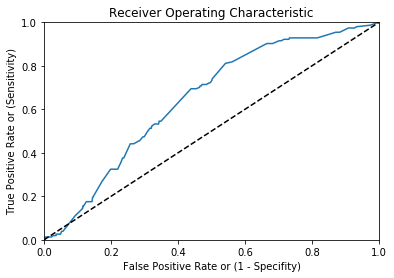

In [63]:
pyplot.plot(rocTest["False positive rate"], rocTest["True positive rate"])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

##### Cumulative Gains Stepwise Forward Logistic Regression

In [64]:
predictions_step=DataFrame(model_step.predict_proba(test_step[step_features]))
actuals_step= test_step["target"]

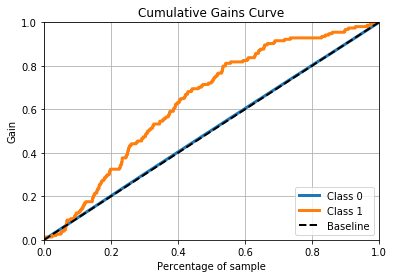

In [65]:
skplt.metrics.plot_cumulative_gain(actuals_step, predictions_step)
pyplot.show()

##### Lift Curve Stepwise Forward Logistic Regression

In [66]:
predictions_step=DataFrame(model_step.predict_proba(test_step[step_features]))
actuals_step= test_step["target"]

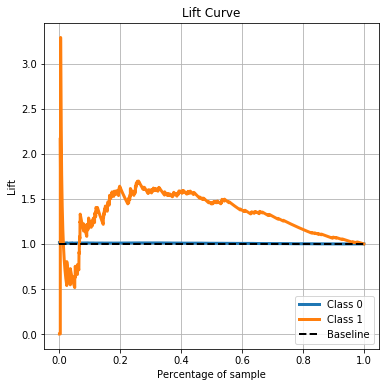

In [67]:
skplt.metrics.plot_lift_curve(actuals_step, predictions_step, figsize= (6, 6))
pyplot.show()

##### 7.3 Gradient Boosting Classifier

In [68]:
# Defining train and test data and model for modeling

from sklearn.ensemble import GradientBoostingClassifier

train_gradient=train[['max_gift', 'avg_amount last 10year', 'sum gifts last 2year', 'avg_amount year one', 
                      'Sum gifts last year']]

test_gradient=test[['max_gift', 'avg_amount last 10year', 'sum gifts last 2year', 'avg_amount year one', 
                    'Sum gifts last year']]

train_gradient_target=train
test_gradient_test=test

Model_GradientBoostingClassifier = GradientBoostingClassifier(max_depth=3,learning_rate=0.02, random_state=123)

In [69]:
# Running Gradient Model

training_subset_X = pd.DataFrame(train_gradient)
test_subset_X = pd.DataFrame(test_gradient)

training_target = pd.DataFrame(train_gradient_target['target'])
test_target = pd.DataFrame(test_gradient_test['target'])

Model_GradientBoostingClassifier.fit(training_subset_X,training_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.02, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

##### AUC Test and AUC Train Gradient Boosting Classifier

In [70]:
y_pred_train = Model_GradientBoostingClassifier.predict(training_subset_X)
y_pred_prob_train = Model_GradientBoostingClassifier.predict_proba(training_subset_X)[:,1]

y_pred_test = Model_GradientBoostingClassifier.predict(test_subset_X)
y_pred_prob_test = Model_GradientBoostingClassifier.predict_proba(test_subset_X)[:,1]

auc_score_train = roc_auc_score(training_target,y_pred_prob_train)
auc_score_test = roc_auc_score(test_target,y_pred_prob_test)
print("AUC Train: ", auc_score_train)
print("AUC Test : ", auc_score_test)

AUC Train:  0.6811802677902882
AUC Test :  0.6794005554991883


##### ROC Curve Gradient Boosting Classifier

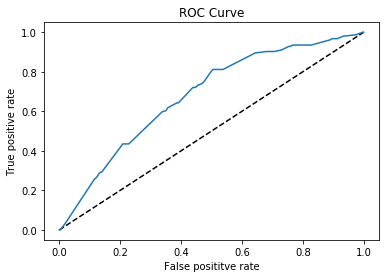

In [71]:
fpr, tpr, thresholds = roc_curve(test_target,y_pred_prob_test)

pyplot.plot([0,1], [0,1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel("False posititve rate")
pyplot.ylabel("True positive rate")
pyplot.title("ROC Curve")
pyplot.show()

##### Cumulative Gains Gradient Boosting Classifier

In [72]:
predictions_bost=Model_GradientBoostingClassifier.predict_proba(test_subset_X)
actuals_bost= test_target["target"]

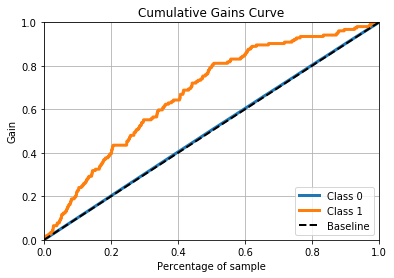

In [73]:
skplt.metrics.plot_cumulative_gain(actuals_bost, predictions_bost)
pyplot.show()

##### Lift Curve Gradient Boosting Classifier

In [74]:
predictions_bost=Model_GradientBoostingClassifier.predict_proba(test_subset_X)
actuals_bost= test_target["target"]

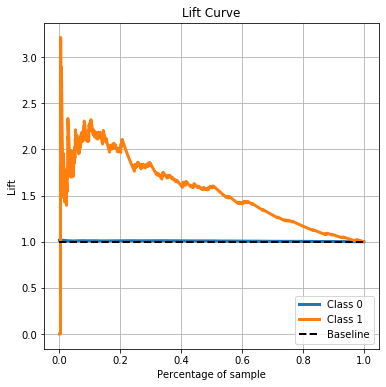

In [75]:
skplt.metrics.plot_lift_curve(actuals_bost, predictions_bost, figsize= (6, 6))
pyplot.show()

##### 7.4 Principal Component Analysis

In [76]:
PC_train=train.drop(['target','donorID','proba target stepwise'],axis=1)
PC_test=test.drop(['target','donorID','proba target stepwise','proba target'], axis=1)

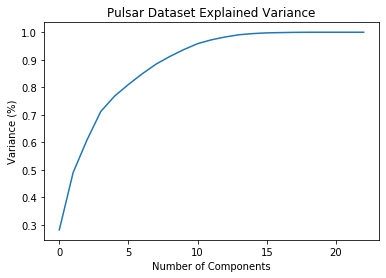

In [77]:
# Defining best number of features reduction

pca2 = PCA().fit(PC_train)
pyplot.figure()
pyplot.plot(np.cumsum(pca2.explained_variance_ratio_))
pyplot.xlabel('Number of Components')
pyplot.ylabel('Variance (%)')
pyplot.title('Pulsar Dataset Explained Variance')
pyplot.show()


In [78]:
# Defining PCA model

pca = PCA(n_components = 15)
pca_train = pca.fit_transform(PC_train)
pca_test = pca.fit_transform(PC_test)
pca_train = pd.DataFrame(pca_train)
pca_test = pd.DataFrame(pca_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


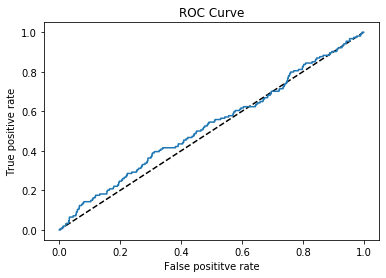

In [79]:
# Running PCA model

training_subset_X = pd.DataFrame(pca_train)
test_subset_X = pd.DataFrame(pca_test)

training_target = pd.DataFrame(train['target'])
test_target = pd.DataFrame(test['target'])

PCA_model = LogisticRegression()

PCA_model.fit(training_subset_X,training_target)

y_pred = PCA_model.predict(test_subset_X)


y_pred_prob = PCA_model.predict_proba(test_subset_X)[:,1]

fpr, tpr, thresholds = roc_curve(test_target,y_pred_prob)

pyplot.plot([0,1], [0,1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel("False posititve rate")
pyplot.ylabel("True positive rate")
pyplot.title("ROC Curve")
pyplot.show()

In [80]:
roc_auc_score(test_target,y_pred_prob)

0.5267251547280845

##### 8. Comparing our best models

#### Cumulative Gains Curves

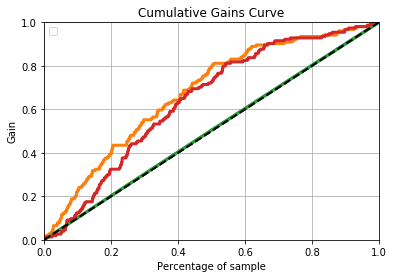

In [81]:
ax2= skplt.metrics.plot_cumulative_gain(actuals_bost, predictions_bost)
skplt.metrics.plot_cumulative_gain(actuals_step, predictions_step, ax=ax2)
pyplot.legend('')
pyplot.show()

#### Lift Curves

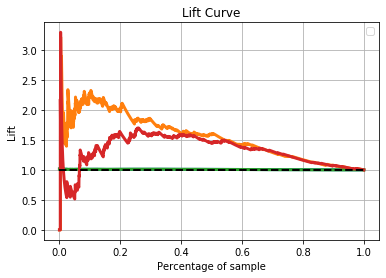

In [82]:
ax = skplt.metrics.plot_lift_curve(actuals_bost, predictions_bost)
plot=skplt.metrics.plot_lift_curve(actuals_step, predictions_step, ax=ax, figsize= (6, 6))
pyplot.legend('')
pyplot.show()

#### ROC Curves

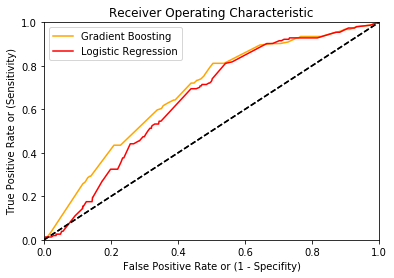

In [83]:
# Gradient Boosting ROC

fpr, tpr, thresholds = roc_curve(test_target,y_pred_prob_test)

pyplot.plot([0,1], [0,1], 'k--')
pyplot.plot(fpr, tpr, label='Gradient Boosting',color='orange')
pyplot.xlabel("False posititve rate")
pyplot.ylabel("True positive rate")

# Stepwise Forward Logistic Regression
pyplot.plot(rocTest["False positive rate"], rocTest["True positive rate"], label= 'Logistic Regression',color='red')
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.0])
pyplot.xlabel("False Positive Rate or (1 - Specifity)")
pyplot.ylabel("True Positive Rate or (Sensitivity)")
pyplot.title("Receiver Operating Characteristic")

pyplot.legend()
pyplot.show()

##### 9. Gradient Boosting Classifier in Test Data 2014

In [84]:
# Defining data for running the model

target_test_f=pd.DataFrame(final_test_set['target'])
test_f=pd.DataFrame(final_test_set[['max_gift', 'avg_amount last 10year', 'sum gifts last 2year', 
                                    'avg_amount year one', 'Sum gifts last year']])

In [85]:
# Making predictions and calculating AUC Test with the previous Gradient Boosting Model

y_pred_test_f = Model_GradientBoostingClassifier.predict(test_f)
y_pred_prob_test_f = Model_GradientBoostingClassifier.predict_proba(test_f)[:,1]

auc_score_test_f = roc_auc_score(target_test_f,y_pred_prob_test_f)
print("AUC Test : ", auc_score_test_f)  #We can see that the AUC Test has an slight variation

AUC Test :  0.6603166000045664


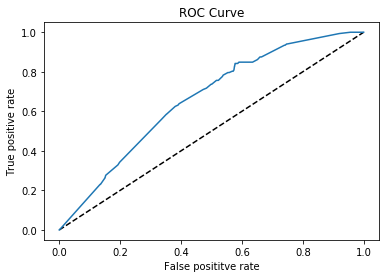

In [86]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(target_test_f,y_pred_prob_test_f)

pyplot.plot([0,1], [0,1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel("False posititve rate")
pyplot.ylabel("True positive rate")
pyplot.title("ROC Curve")
pyplot.show()


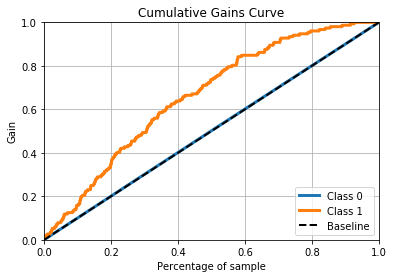

In [87]:
# Cumulative Gains

predictions_bost_final=Model_GradientBoostingClassifier.predict_proba(test_f)
actuals_bost_final= final_test_set["target"]
skplt.metrics.plot_cumulative_gain(actuals_bost_final, predictions_bost_final)
pyplot.show()

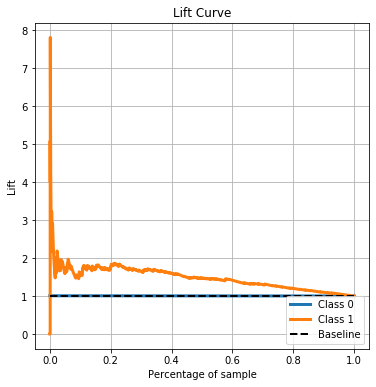

In [88]:
# Lift Curve

predictions_bost_final=Model_GradientBoostingClassifier.predict_proba(test_f)
actuals_bost_final= final_test_set["target"]
skplt.metrics.plot_lift_curve(actuals_bost_final,predictions_bost_final, figsize= (6, 6))
pyplot.show()